## IBM Data Science Coursera Capstone Project Jupyter Notebook

Author: Mark Hanson

#### Background
This Jupyter notebook will be used for the final capstone project in the Coursera IBM Data Science Professional class.  In brief the requirements are to leverage Foursquare location data to explore or compare any choosen neighborhoods or cities or to come up with a problem that can be soloved with data obtained with the Foursquare API. Unfortunately, Foursquare timeseries data is only available to verified managers of Foursquare venues which makes answering some more interesting questions more difficult.

#### Description of my capstone project
For my capstone project I have choosen to cluster the cities in the Minneapolis / Saint Paul 7 county metropolitan area similar to what was done in the labs.  However, in addition to using Foursquare data, I downloaded real estate value data from Zillow and plan to use this to add more detail for the clustering algorithm.  As I get into the analysis I may change or expand the scope or objective of the project by identifying a specific question to answer or adding some more analysis.

Data attribution (sources):
1. Home value data attribution: “Data acquired from Zillow.com/data on April 10, 2019. Aggregated data on this page is made freely available by Zillow for non-commercial use.”
2. Zip code centroid data attribution:
Dataset Identifier: us-zip-code-latitude-and-longitude
License: Creative Commons Attribution-ShareAlike
Modified: February 9, 2018 10:31 AM
Publisher: CivicSpace Labs
Reference: https://boutell.com/zipcodes/
Attributions: Copyright 2004 CivicSpace Labs
Last processing:
February 9, 2018 10:39 AM (metadata)
February 9, 2018 10:39 AM (data)
3. Zip code GeoJSON attributions: https://www.census.gov/cgi-bin/geo/shapefiles2010/layers.cgi & https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md


Changes / additions under consideration:
  Plot a choropleth style map of clusters to better visualize the entire zipcode vs just the bubble marker - When plotting geoJSON subset found counties scattered all over state. Also cluster map seems to leave off many metro area cities / zipcodes - cluster fix started - Hennepin county was misspelled.
  Create a choropleth style heat map of median home prices by zipcode
  Calculate year over year percent change in median home value by zipcode to show which are increasing vs decreasing in value
  
1. Add income by zipcode information - difficult to process from available data
2. Analysis, regression, prediction of median home price change -  Modify df to add year over year % change in median home value
2. Crime rates - not interested in this data
3. Academic achievement - not interested in this data

## Install and import packages

In [1]:
# Install geocoder package with conda
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#print('geopy installed!')

In [2]:
# install folium
#!conda install -c conda-forge folium=0.5.0 --yes
#print('folium installed!')

In [3]:
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [1]:
# import other modules
import pandas as pd
from pandas.io.json import json_normalize

import numpy as np
import requests
import json
import bs4
from bs4 import BeautifulSoup as bs

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [135]:
import folium

**Week 1 assignment**

In [3]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Import Zillow data
**NOTE: While working on project, skip down to section MP 3 and import zill_MSP_data.csv or zill_MSP_data_test.csv instead of recreating entire df.**

Create a new dataframe with Minneapolis / St. Paul 7 county metro area, drop unused columns, rename ZipCode, and reset index

In [49]:
zill_MNWI_df = pd.read_csv('Zillow_Home_Value_Index_MN_WI.csv')
zill_MN_df = zill_MNWI_df[zill_MNWI_df['State']=='MN']
zill_MN_df.shape

(413, 282)

In [156]:
#zill_MNWI_df[zill_MNWI_df['RegionName'] == 55009]

In [84]:
#zill_MSP_df = zill_MN_df[zill_MN_df['CountyName'].isin(['Anoka County','Carver County','Dakota County','Hennepin County','Ramsey County','Washington County'])]

In [100]:
#zill_MSP_df = zill_MSP_df.drop(['RegionID'], axis=1)
#zill_MSP_df = zill_MSP_df.drop(zill_MSP_df.columns.to_series()['1996-04':'2013-12'], axis=1)
#zill_MSP_df = zill_MSP_df.rename(index=str, columns={'RegionName':'ZipCode'})
#zill_MSP_df.reset_index(drop=True, inplace=True)

In [50]:
zill_MN_df = zill_MN_df.drop(['RegionID'], axis=1)
zill_MN_df = zill_MN_df.drop(zill_MNWI_df.columns.to_series()['1996-04':'2013-12'], axis=1)
zill_MN_df = zill_MN_df.rename(index=str, columns={'RegionName':'ZipCode'})
zill_MN_df.reset_index(drop=True, inplace=True)

In [51]:
zill_MN_df.shape

(413, 68)

In [52]:
zill_MSP_df = zill_MN_df[zill_MN_df['CountyName'].isin(['Anoka County','Carver County','Dakota County','Hennepin County','Ramsey County','Scott County','Washington County'])]

In [53]:
print(zill_MSP_df.shape)
zill_MSP_df.head()

(142, 68)


ZipCode          City State                             Metro  \
1    55124  Apple Valley    MN  Minneapolis-St. Paul-Bloomington   
3    55044     Lakeville    MN  Minneapolis-St. Paul-Bloomington   
4    55337    Burnsville    MN  Minneapolis-St. Paul-Bloomington   
5    55106    Saint Paul    MN  Minneapolis-St. Paul-Bloomington   
6    55303        Ramsey    MN  Minneapolis-St. Paul-Bloomington   

      CountyName  SizeRank   2014-01   2014-02   2014-03   2014-04  ...  \
1  Dakota County       472  210700.0  212900.0  214300.0  215700.0  ...   
3  Dakota County       779  272600.0  273700.0  274500.0  276000.0  ...   
4  Dakota County       806  209600.0  210700.0  211400.0  212700.0  ...   
5  Ramsey County       841  120900.0  122100.0  123900.0  125800.0  ...   
6   Anoka County       850  183600.0  183000.0  183200.0  184500.0  ...   

   2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12  \
1   266300   267600   268100   268800   269800   271000   272300   273900   
3   342800   343900   344300   344400   344700   345900   347400   349000   
4   262700   263800   264400   265400   266300   267300   268600   270300   
5   179900   179900   180100   180100   180000   180700   182200   183600   
6   243200   244200   244800   246400   248500   249800   250800   252100   

   2019-01  2019-02  
1   275600   276800  
3   350600   352000  
4   272100   273500  
5   184700   185600  
6   253900   255200  

[5 rows x 68 columns]

## Import Zip Code Centroid Geocoordinates

Notes about geocoordinates
Originally created an empty dataframe then looped through all the cities in the MSP dataframe and added the latitude and longitude data to the new df using geolocator.  Unfortunately, geolocator uses city and state to get latitude and longitude which results in the same information for all the zip codes in a larger city. This is a problem since the home value data is broken down to the finer granularity of zip code.

Found dataset on OpenDataSoft (Civic Space Labs) that links zip code to single geolocation (not boundries as with geoJSON). Used API to get data but could only get 100 records and then got an error which could be a quota limit problem. Not comfortable creating login information since not familiar with site and since data is available for download as csv anyway.  Downloaded and saved as csv

This zipcode data set from OpenDataSoft seems to have all the MN zipcodes but sometimes generalizes the city name (i.e. St. Paul vs Eagan)
Capital Impact website seem to have many of the zipcodes and more specific city names
Zillow data set seems to have the most of the zipcodes but doesn't doesn't always seem to filter to the right list when using county name as filter.
Bottom line: Even raw Zillow dataset doesn't have any more of the 7 county metro zip codes. So just work with zillow dataset of zipcodes

Get zipcode centroid geocoordinates.

In [54]:
# get geocoordinates for a point in each zipcode
MSP_ZipCode_Geo = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep=';')
MSP_ZipCode_Geo.drop(columns=['Timezone','Daylight savings time flag', 'geopoint'], inplace=True)
MSP_ZipCode_Geo = MSP_ZipCode_Geo[MSP_ZipCode_Geo['State'].isin(['MN'])]
MSP_ZipCode_Geo.rename(columns={'Zip':'ZipCode'}, inplace=True)
#MSP_ZipCode_Geo.set_index('ZipCode', inplace=True)
#MSP_ZipCode_Geo[MSP_ZipCode_Geo['ZipCode']==55123]
#MSP_ZipCode_Geo[MSP_ZipCode_Geo['ZipCode'] == 55122]

Merge MSP_ZipCode_Lat_Long df into zill_MSP_df and reoder columns so latitude and longitude are after city and state.

In [55]:
MSP_ZipCode_Geo[MSP_ZipCode_Geo['ZipCode'].isin(zill_MSP_df['ZipCode'])].shape

(141, 5)

In [56]:
# merge geocoordinates by zipcode into home value df
zill_MSP_df = pd.merge(zill_MSP_df, MSP_ZipCode_Geo, on=['ZipCode'])

In [57]:
print(zill_MSP_df.shape)
zill_MSP_df.head()

(141, 72)


ZipCode        City_x State_x                             Metro  \
0    55124  Apple Valley      MN  Minneapolis-St. Paul-Bloomington   
1    55044     Lakeville      MN  Minneapolis-St. Paul-Bloomington   
2    55337    Burnsville      MN  Minneapolis-St. Paul-Bloomington   
3    55106    Saint Paul      MN  Minneapolis-St. Paul-Bloomington   
4    55303        Ramsey      MN  Minneapolis-St. Paul-Bloomington   

      CountyName  SizeRank   2014-01   2014-02   2014-03   2014-04  ...  \
0  Dakota County       472  210700.0  212900.0  214300.0  215700.0  ...   
1  Dakota County       779  272600.0  273700.0  274500.0  276000.0  ...   
2  Dakota County       806  209600.0  210700.0  211400.0  212700.0  ...   
3  Ramsey County       841  120900.0  122100.0  123900.0  125800.0  ...   
4   Anoka County       850  183600.0  183000.0  183200.0  184500.0  ...   

   2018-09  2018-10  2018-11  2018-12  2019-01  2019-02      City_y  State_y  \
0   269800   271000   272300   273900   275600   276800  Saint Paul       MN   
1   344700   345900   347400   349000   350600   352000   Lakeville       MN   
2   266300   267300   268600   270300   272100   273500  Burnsville       MN   
3   180000   180700   182200   183600   184700   185600  Saint Paul       MN   
4   248500   249800   250800   252100   253900   255200       Anoka       MN   

    Latitude  Longitude  
0  44.743963  -93.20624  
1  44.669564  -93.26654  
2  44.770297  -93.27302  
3  44.967565  -93.05001  
4  45.247509  -93.41800  

[5 rows x 72 columns]

In [58]:
# drop city and state from MSP_ZipCode_Geo as they are less specific that those from zill_MSP_df
zill_MSP_df.drop(columns=['City_y','State_y'], inplace=True)
zill_MSP_df.rename(columns={'City_x' : 'City', 'State_x' : 'State'}, inplace=True)

In [59]:
# move geocoordinates from end columns to right after city name
cols = zill_MSP_df.columns.tolist()
cols = cols[0:2] + cols[-2:] + cols[2:-2]
zill_MSP_df = zill_MSP_df[cols]

In [124]:
# write zill_MSP_df to csv so don't have to recreate it everytime using slow geolocator
#zill_MSP_df.to_csv(path_or_buf='zill_MSP_data.csv')

## Load cleaned data set from CSV
While working on project, import zill_MSP_data.csv to df instead of re-creating it each time.

**Work with full dataset**

In [60]:
zill_MSP_df = pd.read_csv('zill_MSP_data.csv')
zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])

**Work with test dataset**

In [15]:
#zill_MSP_df = pd.read_csv('zill_MSP_data_test.csv')
#zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])

How may zipcodes in say St. Paul?

In [61]:
#zill_MSP_df[zill_MSP_df['City']=='Saint Paul']
zill_MSP_df.head()

ZipCode          City   Latitude  Longitude State  \
0    55124  Apple Valley  44.743963  -93.20624    MN   
1    55044     Lakeville  44.669564  -93.26654    MN   
2    55337    Burnsville  44.770297  -93.27302    MN   
3    55106    Saint Paul  44.967565  -93.05001    MN   
4    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank   2014-01  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472  210700.0   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779  272600.0   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806  209600.0   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841  120900.0   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850  183600.0   

    2014-02  ...  2018-05  2018-06  2018-07  2018-08  2018-09  2018-10  \
0  212900.0  ...   266300   267600   268100   268800   269800   271000   
1  273700.0  ...   342800   343900   344300   344400   344700   345900   
2  210700.0  ...   262700   263800   264400   265400   266300   267300   
3  122100.0  ...   179900   179900   180100   180100   180000   180700   
4  183000.0  ...   243200   244200   244800   246400   248500   249800   

   2018-11  2018-12  2019-01  2019-02  
0   272300   273900   275600   276800  
1   347400   349000   350600   352000  
2   268600   270300   272100   273500  
3   182200   183600   184700   185600  
4   250800   252100   253900   255200  

[5 rows x 70 columns]

Original data set had 12 zip codes in St. Paul all with the same geolocation. Venue data uses that geolocation so all of St. Paul would have the same venues regardless of zip code.  Zillow home value data has data for each zip code.  This mismatch would have obscured the relationship between home values and venues resulting in poor classifications.

By getting geolocations for each zip code online the mismatch is resolved and each zip code can have an associated list of venues around it.  Originally had issues with rural locations having no venues (too small a radius) and urban locations being classified together due to too large a radius so experimented with radius and eliminating rural areas by limiting to 7 county metro area. Ultimately selected a 1.61km (1mi) radius around each zip code geolocation and ran query during business hours.

## Explore Cities in the 7 county Minneapolis-St.Paul metropolitan area

Let's create a function to get FourSquare venue data for all the cities in the Minneapolis-St.Paul metro area

In [128]:
# Four square credentials

In [129]:
# set radius to 1610m (approx 1 mi) and limit search to 100 venues; Check to see if all zipcodes have venues and drop those that don't
radius = 1610
LIMIT = 100

In [130]:
def getNearbyVenues(zipcode, names, latitudes, longitudes):
    
    venues_list=[]
    for zipcode, name, lat, lng in zip(zipcode, names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # deal with case where rural zipcodes are bigger and venues might not be found within 2km so increase to 5km
#        if results == []:
#            rad = 5000
        
        # return only relevant information for each nearby venue                
        venues_list.append([(
            zipcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode','City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called MSP_venues.

In [135]:
MSP_venues = getNearbyVenues(zipcode = zill_MSP_df['ZipCode'], names = zill_MSP_df['City'], latitudes = zill_MSP_df['Latitude'], longitudes = zill_MSP_df['Longitude'])

Notice that slightly different geocoordinates exist for city and venue

In [62]:
print('There are {} uniques categories.'.format(len(MSP_venues['Venue Category'].unique())))

There are 376 uniques categories.


In [137]:
# write MSP_venues df to csv so don't have to recreate it everytime also time dependent last run and saved 8:13AM 4/24/19
#MSP_venues.to_csv(path_or_buf='MSP_venues_data.csv')

In [63]:
# read MSP_venues df from csv so don't have to run as many queries against Foursquare
#MSP_venues = pd.read_csv('MSP_venues_data.csv')
#MSP_venues = MSP_venues.drop(columns=['Unnamed: 0'])
print(MSP_venues.shape)
MSP_venues.head()

(5186, 8)


ZipCode          City  City Latitude  City Longitude         Venue  \
0    55124  Apple Valley      44.743963       -93.20624     Five Guys   
1    55124  Apple Valley      44.743963       -93.20624    Satay 2 Go   
2    55124  Apple Valley      44.743963       -93.20624     Kwik Trip   
3    55124  Apple Valley      44.743963       -93.20624  Cole's Salon   
4    55124  Apple Valley      44.743963       -93.20624  Jimmy John's   

   Venue Latitude  Venue Longitude      Venue Category  
0       44.735794       -93.216446        Burger Joint  
1       44.731270       -93.201148    Asian Restaurant  
2       44.739600       -93.218739   Convenience Store  
3       44.731770       -93.216405  Salon / Barbershop  
4       44.733264       -93.206591      Sandwich Place

While working on project, import MSP_venues.csv to df instead of re-creating it each time.

In [92]:
#MSP_venues[MSP_venues['ZipCode'].isin(missing_zipcode)]

## Analyze Each Neighborhood

In [64]:
# one hot encoding
MSP_onehot = pd.get_dummies(MSP_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
MSP_onehot['ZipCode'] = MSP_venues['ZipCode'] 

# move city column to the first column
fixed_columns = [MSP_onehot.columns[-1]] + list(MSP_onehot.columns[:-1])
MSP_onehot = MSP_onehot[fixed_columns]

#MSP_onehot.head()

In [65]:
MSP_onehot.shape

(5186, 377)

In [66]:
# list the average number of venues of each type in each zipcode
MSP_grouped = MSP_onehot.groupby('ZipCode').mean().reset_index()
MSP_grouped.shape

(141, 377)

Troubleshooting: Find the zipcodes that are in zill_MSP_df that are missing in MSP_grouped

In [17]:
#city_venues_sorted_ZipCode_List = city_venues_sorted['ZipCode'].tolist()
#len(city_venues_sorted_ZipCode_List)

In [67]:
def compare_lists(list_a, list_b):
    missing_in_b = []
    for x in list_a:
        if x not in list_b:
            missing_in_b.append(x)
#        print('zill: ', x)
    return missing_in_b

In [68]:
zill_ZipCode_List = zill_MSP_df['ZipCode'].tolist()
len(zill_ZipCode_List)

141

In [74]:
#zill_MSP_df[zill_MSP_df['ZipCode'].isin(missing_zipcode)]
# filter out WI earlier up in analysis!

In [39]:
compare_lists(city_venues_sorted_ZipCode_List, zill_ZipCode_List)

[]

Function to sort the venues in descending order.

In [69]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [70]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['ZipCode'] = MSP_grouped['ZipCode']

for ind in np.arange(MSP_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MSP_grouped.iloc[ind, :], num_top_venues)

#city_venues_sorted.head()

In [71]:
city_venues_sorted.shape

(141, 11)

In [72]:
city_venues_sorted.head()

ZipCode 1st Most Common Venue 2nd Most Common Venue  \
0    55001    Athletics & Sports           Zoo Exhibit   
1    55003                  Park        Breakfast Spot   
2    55005        Sandwich Place      Business Service   
3    55011                Forest        Hardware Store   
4    55014   American Restaurant           Pizza Place   

         3rd Most Common Venue        4th Most Common Venue  \
0  Eastern European Restaurant            Elementary School   
1                Boat or Ferry      Comfort Food Restaurant   
2                  Gas Station  Eastern European Restaurant   
3                  Zoo Exhibit                         Farm   
4         Fast Food Restaurant               Baseball Field   

     5th Most Common Venue  6th Most Common Venue  7th Most Common Venue  \
0       English Restaurant  Entertainment Service   Ethiopian Restaurant   
1  New American Restaurant     Athletics & Sports                    Bar   
2        Electronics Store      Elementary School     English Restaurant   
3        Elementary School     English Restaurant  Entertainment Service   
4               Playground            Video Store         Massage Studio   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0            Event Space               Exhibit             Eye Doctor  
1              BBQ Joint           Video Store            Zoo Exhibit  
2  Entertainment Service  Ethiopian Restaurant            Event Space  
3   Ethiopian Restaurant           Event Space                Exhibit  
4          Big Box Store                   Bar               Cemetery

## Cluster Cities from venues and Feb 2019 median home value data sets

Create MSP_med_HV df with latest median home value for each zipcode

In [73]:
# keep first 2 columns and last column from zill_MSP_df in new median home value df
cols1 = zill_MSP_df.columns.tolist()
cols1 = cols1[0:2] + cols1[-1:]    # + cols1[3:-2]
MSP_med_HV = zill_MSP_df[cols1]
#MSP_med_HV.head()

In [74]:
# join home value from feb 2019 with grouped venue by zipcode data
MSP_grouped_HV_clustering = MSP_grouped
MSP_grouped_HV_clustering = MSP_grouped_HV_clustering.join(MSP_med_HV.set_index('ZipCode'), on='ZipCode')
#MSP_grouped_HV_clustering.head()

In [75]:
# after joining with median home value df move median home value to first column
cols2 = MSP_grouped_HV_clustering.columns.tolist()
cols2 = cols2[-1:] + cols2[1:-2] #+ cols2[:] # + cols2[-1:] + cols2[1:-2]
#cols2
MSP_grouped_HV_clustering = MSP_grouped_HV_clustering[cols2]
#MSP_grouped_HV_clustering.head()

Begin clustering and identify optimum number of clusters. This data set has home value and venues together before clustering

Rename home value column and normalize it

Normalize home value data so that clusters take into account venue data. Pick feature range for home value scaling such that it is given more weight which is both meaningful - as home value is likely most important - and also produces a knee to enable to select an appropriate k (number of clusters).

In [76]:
MSP_grouped_HV_clustering.rename(columns={'2019-02':'Feb-2019 Median Home Value'}, inplace=True)

In [77]:
# create df with normalized home values in range between 1 and 100
MSP_grouped_HV_Norm_clustering = MSP_grouped_HV_clustering
scaler = MinMaxScaler(feature_range=(1,100))
MSP_grouped_HV_Norm_clustering.iloc[:,0:1] = scaler.fit_transform(MSP_grouped_HV_Norm_clustering['Feb-2019 Median Home Value'].values.reshape(-1,1))

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [78]:
MSP_grouped_HV_Norm_clustering.shape

(141, 377)

In [79]:
MSP_grouped_HV_Norm_clustering.head()

Feb-2019 Median Home Value  ATM  Accessories Store  Acupuncturist  \
0                   51.076067  0.0                0.0            0.0   
1                   14.825603  0.0                0.0            0.0   
2                   15.977737  0.0                0.0            0.0   
3                   19.283859  0.0                0.0            0.0   
4                   17.413729  0.0                0.0            0.0   

   Adult Boutique  Advertising Agency  Afghan Restaurant  African Restaurant  \
0             0.0                 0.0                0.0                 0.0   
1             0.0                 0.0                0.0                 0.0   
2             0.0                 0.0                0.0                 0.0   
3             0.0                 0.0                0.0                 0.0   
4             0.0                 0.0                0.0                 0.0   

   Airport  Airport Service  ...  Weight Loss Center  Whisky Bar  Wine Bar  \
0      0.0              0.0  ...                 0.0         0.0       0.0   
1      0.0              0.0  ...                 0.0         0.0       0.0   
2      0.0              0.0  ...                 0.0         0.0       0.0   
3      0.0              0.0  ...                 0.0         0.0       0.0   
4      0.0              0.0  ...                 0.0         0.0       0.0   

   Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0        0.0     0.0          0.0            0.0          0.0  0.0   
1        0.0     0.0          0.0            0.0          0.0  0.0   
2        0.0     0.0          0.0            0.0          0.0  0.0   
3        0.0     0.0          0.0            0.0          0.0  0.0   
4        0.0     0.0          0.0            0.0          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 377 columns]

## Evaluate k- means accuracy
Evaluate and graph accuracy - as measured by inertia - with various values of k (number of clusters) and select the k value at or around the knee point. 
    external approach - compare clusters with ground truth, if available
    internal approach - average of the distance between data points within a cluster and average of the distances of data points from their cluster centroids.
    Calculate and graph the accuracy (i.e. error) as the mean distance of data points from their cluster centroid

In [154]:
# set number of clusters as range from 1 to 50
kclusters = range(1,70)
k_inertia = []
k_val = []
unity_start = []   # array position where clusters start to contain only 1 zipcode

# run k-means clustering
for k in kclusters:
    kmeans = KMeans(init = "k-means++", n_clusters=k, random_state=0).fit(MSP_grouped_HV_Norm_clustering)
    k_val.append(k)
    k_inertia.append(kmeans.inertia_)
    
# find where first cluster with only one entry starts
    cluster_density = pd.Series(kmeans.labels_).value_counts()
    i = 0
    first_one = 0
    for elem in cluster_density:
        if elem != 1:
            i+=1
        else:
            first_one = i
    unity_start.append(first_one)

In [155]:
unistart = []
eff_ratio = []

for i, j in zip(k_val,unity_start):
    unistart.append(j)
    eff_ratio.append(j/i)
#k_minus_unistart[34:36]
#eff_ratio[0:12]
#del k_inertia
#del k_val

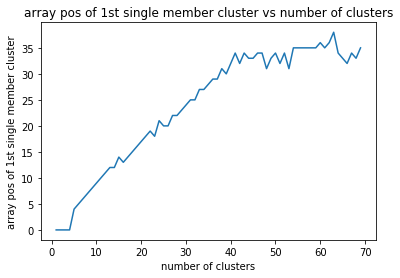

In [156]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# plot k-means inertia (to be minimized) vs number of clusters k. Select knee point in graph
ax.plot(k_val, unistart)

# Title of the plot
ax.set_title('array pos of 1st single member cluster vs number of clusters')

ax.set_xlabel('number of clusters')
ax.set_ylabel('array pos of 1st single member cluster')
#ax.set_xlim([15,20])
#ax.set_ylim([-1,40])

plt.show()

In [157]:
unistart[7:20]

[7, 8, 9, 10, 11, 12, 12, 14, 13, 14, 15, 16, 17]

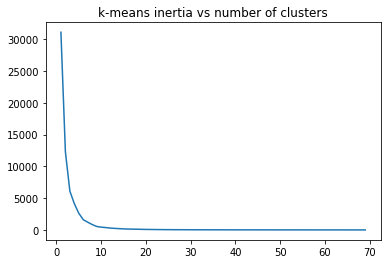

In [158]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# plot k-means inertia (to be minimized) vs number of clusters k. Select knee point in graph
ax.plot(k_val, k_inertia)

# Title of the plot
ax.set_title('k-means inertia vs number of clusters')
#ax.set_ylim(bottom=0, top=1000)
#ax.set_xlim(left=0, right=20)

plt.show()

In [160]:
k_inertia[7:20]

[845.1649048904916,
 547.1656004609456,
 442.8229812630951,
 375.80698268037753,
 293.53704862834786,
 246.63168000869322,
 205.80276630305337,
 168.24851344915774,
 139.63002007191557,
 128.21534615799715,
 113.60161468193782,
 99.20228398855907,
 82.58415526935102]

In [161]:
kmeans.labels_

array([14, 21, 66, 51, 57, 35, 60, 38, 42, 47, 35, 44, 37, 35,  9, 50, 47,
       24, 68, 12, 24, 36,  9, 19, 34, 28, 64, 24, 33,  8, 29, 33, 22, 42,
        8, 63, 57, 18, 21, 29, 20, 19, 35, 19, 48, 35, 58, 53, 38, 47, 44,
        3, 21, 52, 31, 13, 53, 26, 55, 67, 31, 43, 65, 46, 62,  2, 58,  6,
        1, 31, 23, 54, 28, 12, 25, 15, 56, 45, 47,  4, 58, 30, 30, 32, 26,
       18, 43, 27, 32,  1, 16, 49, 47,  1, 36, 43, 63, 31, 59, 65, 40, 61,
       11, 58, 65, 10, 20, 12, 35, 43, 41, 19, 34, 31,  5, 34, 12, 63, 24,
        4, 22, 38, 24, 24,  8, 39,  7, 47, 17, 30, 20, 18, 34, 21,  0, 15,
       34,  3, 11, 34, 41], dtype=int32)

## After selecting number of clusters, re-run k-means

In [31]:
kclusters = 10
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(MSP_grouped_HV_Norm_clustering)

In [32]:
cluster_density = pd.Series(kmeans.labels_).value_counts()
cluster_density

5    27
2    23
0    22
9    18
6    18
3    14
8     9
1     6
7     3
4     1
dtype: int64

## Create Merged Dataset for Cluster Map
So now that we have the data and the KMeans model initialized, let's plot them and see what it looks like!

In [80]:
# select basic info and feb 2019 home value data columns from zill_MSP_df to merge with venue data
cols3 = zill_MSP_df.columns.tolist()
cols3 = cols3[0:8] + cols3[-1:]
#cols3

In [81]:
# create MSP_merged as seed for merging with venues data
MSP_merged = zill_MSP_df[cols3]

In [82]:
# give feb 2019 home value data a more descriptive name
MSP_merged.rename(columns={'2019-02':'Feb-2019 Median Home Value'}, inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [85]:
#MSP_merged['Feb-2019 Median Home Value'] = MSP_merged['Feb-2019 Median Home Value'].apply(lambda x: "${:.0f}K".format((x/1000)))
MSP_merged.shape

(141, 9)

In [470]:
# drop clustering labels
#city_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)

In [467]:
# add clustering labels
#city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [86]:
# merge home value by zipcode and geocoordinates with venue data
MSP_merged = MSP_merged.join(city_venues_sorted.set_index('ZipCode'), on='ZipCode')

In [87]:
MSP_merged.insert(0,'Cluster Labels', kmeans.labels_)

In [86]:
#MSP_merged['Cluster Labels'].value_counts()

In [88]:
MSP_merged.head()
#kmeans.labels_.shape

Cluster Labels  ZipCode          City   Latitude  Longitude State  \
0               1    55124  Apple Valley  44.743963  -93.20624    MN   
1               5    55044     Lakeville  44.669564  -93.26654    MN   
2               5    55337    Burnsville  44.770297  -93.27302    MN   
3               9    55106    Saint Paul  44.967565  -93.05001    MN   
4               5    55303        Ramsey  45.247509  -93.41800    MN   

                              Metro     CountyName  SizeRank  \
0  Minneapolis-St. Paul-Bloomington  Dakota County       472   
1  Minneapolis-St. Paul-Bloomington  Dakota County       779   
2  Minneapolis-St. Paul-Bloomington  Dakota County       806   
3  Minneapolis-St. Paul-Bloomington  Ramsey County       841   
4  Minneapolis-St. Paul-Bloomington   Anoka County       850   

   Feb-2019 Median Home Value 1st Most Common Venue 2nd Most Common Venue  \
0                      276800                  Park           Coffee Shop   
1                      352000                 Beach           Golf Course   
2                      273500           Coffee Shop           Pizza Place   
3                      185600    Mexican Restaurant         Grocery Store   
4                      255200     Convenience Store            Playground   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Pizza Place   American Restaurant     Mobile Phone Shop   
1                  Lake      Football Stadium          Skating Rink   
2           Video Store                 Hotel        Sandwich Place   
3                  Park              Dive Bar                   Gym   
4            Campground               Dog Run  Outdoor Supply Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0    Mexican Restaurant        Sandwich Place          Soccer Field   
1      Department Store       Harbor / Marina            Restaurant   
2    Salon / Barbershop           Supermarket            Smoke Shop   
3  Gym / Fitness Center        Sandwich Place  Fast Food Restaurant   
4      Business Service           Zoo Exhibit    Falafel Restaurant   

   9th Most Common Venue 10th Most Common Venue  
0       Asian Restaurant      Convenience Store  
1              Disc Golf            Zoo Exhibit  
2           Skating Rink             Skate Park  
3               Pharmacy            Pizza Place  
4  Entertainment Service   Ethiopian Restaurant

## Create Cluster Map

Set latitude and longitude for St. Paul

In [89]:
# set st. paul as map starting point
latitude = 44.9537
longitude = -93.0900
#print(latitude, longitude)

In [90]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, poi, med_hv, cluster in zip(MSP_merged['Latitude'], MSP_merged['Longitude'], MSP_merged['City'], MSP_merged['ZipCode'], MSP_merged['Feb-2019 Median Home Value'], MSP_merged['Cluster Labels']):
#    fancy_label = ' Cluster: ' + str(cluster) + '<br>' + 'City: ' + str(city) + '<br>' + 'Zipcode: ' + str(poi) +'<br>' + ' Feb-2019 Median Home Value: ' + '${:,.0f}'.format(med_hv)
    fancy_label = ' Cluster: ' + str(cluster) + '<br>' + 'City: ' + str(city) + '<br>' + 'Zipcode: ' + str(poi) +'<br>' + ' Feb-2019 Median Home Value: ' + '${:,.0f}K'.format(med_hv/1000)
    iframe = folium.IFrame(html=fancy_label, width=300, height=90)
    label = folium.Popup(iframe, max_width=2650, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Examine each cluster and determine the discriminating median home value and venue categories that distinguish each cluster. Based on the defining categories, assign a name to each cluster.

#### Cluster 0

In [91]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 0, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode                   City   Latitude  Longitude  \
17                0    55423              Richfield  44.877164  -93.28124   
20                0    55082             Stillwater  45.054551  -92.82581   
21                0    55414            Minneapolis  44.980379  -93.23003   
23                0    55433            Coon Rapids  45.163848  -93.31950   
24                0    55122                  Eagan  44.804548  -93.19871   
27                0    55432                Fridley  45.095674  -93.25336   
29                0    55404            Minneapolis  44.963365  -93.26179   
34                0    55421       Columbia Heights  45.050434  -93.25007   
41                0    55033               Hastings  44.726517  -92.86147   
43                0    55403            Minneapolis  44.971765  -93.28557   
91                0    55107             Saint Paul  44.928315  -93.08876   
94                0    55444          Brooklyn Park  45.106065  -93.30461   
111               0    55386               Victoria  44.858595  -93.66341   
112               0    55070          Saint Francis  45.395912  -93.37005   
115               0    55356                  Orono  44.985463  -93.58388   
118               0    55415            Minneapolis  44.973415  -93.25941   
122               0    55005            East Bethel  45.395494  -93.23584   
123               0    55327                 Dayton  45.217054  -93.47612   
124               0    55043               Lakeland  44.931600  -92.77001   
132               0    55001                  Afton  44.903133  -92.81904   
136               0    55368  Norwood Young America  44.756883  -93.91666   
139               0    55031                Hampton  44.607553  -92.98548   

    State                             Metro         CountyName  SizeRank  \
17     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      1743   
20     MN  Minneapolis-St. Paul-Bloomington  Washington County      2120   
21     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      2290   
23     MN  Minneapolis-St. Paul-Bloomington       Anoka County      2489   
24     MN  Minneapolis-St. Paul-Bloomington      Dakota County      2506   
27     MN  Minneapolis-St. Paul-Bloomington       Anoka County      2824   
29     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      2846   
34     MN  Minneapolis-St. Paul-Bloomington       Anoka County      3146   
41     MN  Minneapolis-St. Paul-Bloomington      Dakota County      3355   
43     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      3591   
91     MN  Minneapolis-St. Paul-Bloomington      Ramsey County      7297   
94     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      7573   
111    MN  Minneapolis-St. Paul-Bloomington      Carver County      9875   
112    MN  Minneapolis-St. Paul-Bloomington       Anoka County      9906   
115    MN  Minneapolis-St. Paul-Bloomington    Hennepin County     10871   
118    MN  Minneapolis-St. Paul-Bloomington    Hennepin County     11064   
122    MN  Minneapolis-St. Paul-Bloomington       Anoka County     12002   
123    MN  Minneapolis-St. Paul-Bloomington    Hennepin County     12222   
124    MN  Minneapolis-St. Paul-Bloomington  Washington County     12426   
132    MN  Minneapolis-St. Paul-Bloomington  Washington County     13401   
136    MN  Minneapolis-St. Paul-Bloomington      Carver County     13706   
139    MN  Minneapolis-St. Paul-Bloomington      Dakota County     14794   

     Feb-2019 Median Home Value       1st Most Common Venue  \
17                       253600          Mexican Restaurant   
20                       360900             Bed & Breakfast   
21                       298200                 Pizza Place   
23                       229500                 Pizza Place   
24                       273700                 Pizza Place   
27                       227300         American Restaurant   
29                       222900            

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b394b9400>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b3952ceb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b394b9198>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b3952c2e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b3952cc18>],
 'means': []}

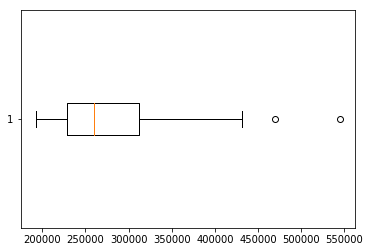

In [92]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 0, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 1

In [93]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 1, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode             City   Latitude  Longitude State  \
0                 1    55124     Apple Valley  44.743963  -93.20624    MN   
12                1    55304          Andover  45.254715  -93.28652    MN   
67                1    55316         Champlin  45.170714  -93.38452    MN   
100               1    55425      Bloomington  44.846765  -93.24490    MN   
125               1    55055          Newport  44.871166  -93.00187    MN   
128               1    55020  Elko New Market  44.571365  -93.36011    MN   

                                Metro         CountyName  SizeRank  \
0    Minneapolis-St. Paul-Bloomington      Dakota County       472   
12   Minneapolis-St. Paul-Bloomington       Anoka County      1544   
67   Minneapolis-St. Paul-Bloomington    Hennepin County      5146   
100  Minneapolis-St. Paul-Bloomington    Hennepin County      8320   
125  Minneapolis-St. Paul-Bloomington  Washington County     12475   
128  Minneapolis-St. Paul-Bloomington       Scott County     12843   

     Feb-2019 Median Home Value       1st Most Common Venue  \
0                        276800                        Park   
12                       316100                        Park   
67                       255100                 Pizza Place   
100                      240200              Clothing Store   
125                      225400  Construction & Landscaping   
128                      326000           Convenience Store   

          2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   Coffee Shop           Pizza Place   American Restaurant   
12   Construction & Landscaping                   Pub           Pizza Place   
67         Fast Food Restaurant           Coffee Shop                   Gym   
100              Cosmetics Shop                 Hotel           Coffee Shop   
125          Italian Restaurant   Monument / Landmark  Fast Food Restaurant   
128                 Pizza Place                   Bar       Photography Lab   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0       Mobile Phone Shop    Mexican Restaurant        Sandwich Place   
12             Eye Doctor           Zoo Exhibit    Falafel Restaurant   
67          Grocery Store                  Park          Liquor Store   
100        Sandwich Place   Sporting Goods Shop        Lingerie Store   
125        Sandwich Place              Dive Bar    Athletics & Sports   
128   American Restaurant  Gym / Fitness Center           Zoo Exhibit   

    8th Most Common Venue 9th Most Common Venue   10th Most Common Venue  
0            Soccer Field      Asian Restaurant        Convenience Store  
12      Electronics Store     Elementary School       English Restaurant  
67    American Restaurant        Sandwich Place  New American Restaurant  
100            Theme Park      Toy / Game Store                   Bakery  
125                 Diner        Clothing Store                     Park  
128                  Farm    English Restaurant    Entertainment Service

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b39500390>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b394f8dd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b39500b00>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b394f8588>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b394f8898>],
 'means': []}

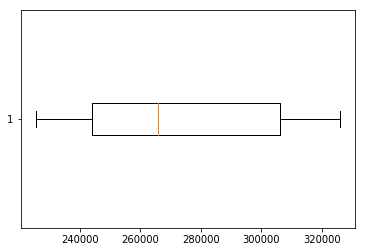

In [94]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 1, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 2

In [95]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 2, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode              City   Latitude  Longitude State  \
6                 2    55104        Saint Paul  44.953665  -93.15922    MN   
9                 2    55408       Minneapolis  44.947515  -93.28742    MN   
11                2    55117        Saint Paul  44.989065  -93.10666    MN   
16                2    55119        Saint Paul  44.957315  -93.00616    MN   
18                2    55369       Maple Grove  45.120764  -93.43183    MN   
49                2    55448       Coon Rapids  45.186232  -93.29635    MN   
50                2    55449            Blaine  45.168287  -93.20001    MN   
51                2    55318            Chaska  44.809954  -93.61050    MN   
55                2    55378            Savage  44.761796  -93.37220    MN   
57                2    55102        Saint Paul  44.935315  -93.12049    MN   
62                2    55123             Eagan  44.804048  -93.13378    MN   
63                2    55420       Bloomington  44.837964  -93.27657    MN   
64                2    55129          Woodbury  44.896938  -92.90241    MN   
78                2    55344      Eden Prairie  44.867013  -93.42557    MN   
83                2    55391           Wayzata  44.963063  -93.52912    MN   
84                2    55401       Minneapolis  44.984615  -93.27137    MN   
88                2    55346      Eden Prairie  44.880435  -93.48690    MN   
92                2    55442          Plymouth  45.046701  -93.42892    MN   
99                2    56071        New Prague  44.546463  -93.57848    MN   
104               2    55439             Edina  44.875997  -93.37021    MN   
126               2    55375  Saint Bonifacius  44.906512  -93.74390    MN   
127               2    55073           Scandia  45.275771  -92.83001    MN   
137               2    55003           Bayport  45.017767  -92.78039    MN   

                                Metro         CountyName  SizeRank  \
6    Minneapolis-St. Paul-Bloomington      Ramsey County       955   
9    Minneapolis-St. Paul-Bloomington    Hennepin County      1238   
11   Minneapolis-St. Paul-Bloomington      Ramsey County      1475   
16   Minneapolis-St. Paul-Bloomington      Ramsey County      1687   
18   Minneapolis-St. Paul-Bloomington    Hennepin County      1922   
49   Minneapolis-St. Paul-Bloomington       Anoka County      3916   
50   Minneapolis-St. Paul-Bloomington       Anoka County      3940   
51   Minneapolis-St. Paul-Bloomington      Carver County      3955   
55   Minneapolis-St. Paul-Bloomington       Scott County      4124   
57   Minneapolis-St. Paul-Bloomington      Ramsey County      4334   
62   Minneapolis-St. Paul-Bloomington      Dakota County      4624   
63   Minneapolis-St. Paul-Bloomington    Hennepin County      4672   
64   Minneapolis-St. Paul-Bloomington  Washington County      4802   
78   Minneapolis-St. Paul-Bloomington    Hennepin County      5882   
83   Minneapolis-St. Paul-Bloomington    Hennepin County      6317   
84   Minneapolis-St. Paul-Bloomington    Hennepin County      6384   
88   Minneapolis-St. Paul-Bloomington    Hennepin County      6757   
92   Minneapolis-St. Paul-Bloomington    Hennepin County      7397   
99   Minneapolis-St. Paul-Bloomington       Scott County      8081   
104  Minneapolis-St. Paul-Bloomington    Hennepin County      8978   
126  Minneapolis-St. Paul-Bloomington    Hennepin County     12476   
127  Minneapolis-St. Paul-Bloomington  Washington County     12796   
137  Minneapolis-St. Paul-Bloomington  Washington County     13770   

     Feb-2019 Median Home Value 1st Most Common Venue   2nd Most Common Venue  \
6                        234800           Coffee Shop  Thrift / Vintage Store   
9                        286600           Coffee Shop             Pizza Place   
11                       213500  Fast Food Restaurant                     Bar   
16                       212700  Fast Food Restaurant             Pizza Place   
18                       274100          Dance

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b39476390>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b37beee48>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b39476160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b37bee7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b37bee278>],
 'means': []}

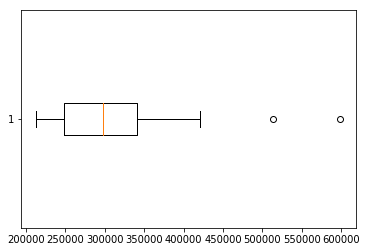

In [96]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 2, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 3

In [97]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 3, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode              City   Latitude  Longitude State  \
15                3    55110   White Bear Lake  45.081266  -93.01146    MN   
25                3    55109         Maplewood  45.010632  -93.01845    MN   
44                3    55105        Saint Paul  44.934465  -93.16554    MN   
53                3    55429   Brooklyn Center  45.064714  -93.34155    MN   
61                3    55446          Plymouth  45.039312  -93.47988    MN   
70                3    55410       Minneapolis  44.911564  -93.31947    MN   
72                3    55075  South Saint Paul  44.887966  -93.04546    MN   
76                3    55430   Brooklyn Center  45.059265  -93.29977    MN   
86                3    55108        Saint Paul  44.982515  -93.17489    MN   
87                3    55364             Mound  44.933712  -93.66038    MN   
95                3    55374            Rogers  45.197646  -93.57104    MN   
105               3    55011       East Bethel  45.335128  -93.27434    MN   
109               3    55115         Mahtomedi  45.060048  -92.95762    MN   
134               3    55360             Mayer  44.909362  -93.89981    MN   

                                Metro         CountyName  SizeRank  \
15   Minneapolis-St. Paul-Bloomington      Ramsey County      1639   
25   Minneapolis-St. Paul-Bloomington      Ramsey County      2549   
44   Minneapolis-St. Paul-Bloomington      Ramsey County      3678   
53   Minneapolis-St. Paul-Bloomington    Hennepin County      4001   
61   Minneapolis-St. Paul-Bloomington    Hennepin County      4597   
70   Minneapolis-St. Paul-Bloomington    Hennepin County      5316   
72   Minneapolis-St. Paul-Bloomington      Dakota County      5374   
76   Minneapolis-St. Paul-Bloomington    Hennepin County      5719   
86   Minneapolis-St. Paul-Bloomington      Ramsey County      6716   
87   Minneapolis-St. Paul-Bloomington    Hennepin County      6720   
95   Minneapolis-St. Paul-Bloomington    Hennepin County      7645   
105  Minneapolis-St. Paul-Bloomington       Anoka County      8998   
109  Minneapolis-St. Paul-Bloomington  Washington County      9340   
134  Minneapolis-St. Paul-Bloomington      Carver County     13590   

     Feb-2019 Median Home Value 1st Most Common Venue  \
15                       263200                   Bar   
25                       233600        Sandwich Place   
44                       363700           Pizza Place   
53                       207200              Pharmacy   
61                       393100                  Park   
70                       471200           Coffee Shop   
72                       214900                   Bar   
76                       194000                  Park   
86                       290100   American Restaurant   
87                       316000          Liquor Store   
95                       331900           Coffee Shop   
105                      279100                Forest   
109                      364800              Dive Bar   
134                      268000                  Farm   

          2nd Most Common Venue       3rd Most Common Venue  \
15                     Pharmacy                 Pizza Place   
25         Gym / Fitness Center              Shipping Store   
44                       Bakery                 Coffee Shop   
53        Vietnamese Restaurant         Rental Car Location   
61                  Golf Course  Construction & Landscaping   
70           Italian Restaurant                        Park   
72               Sandwich Place           Electronics Store   
76                  Pizza Place              Discount Store   
86                  Zoo Exhibit                 Snack Place   
87                  Pizza Place                        Park   
95         Fast Food Restaurant                 Video Store   
105              Hardware Store                 Zoo Exhibit   
109          Italian Restaurant         American Restaurant   
134  Construction & Landscaping              

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b343c8940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b343c8fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b343c87f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b343d46a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b343d49e8>],
 'means': []}

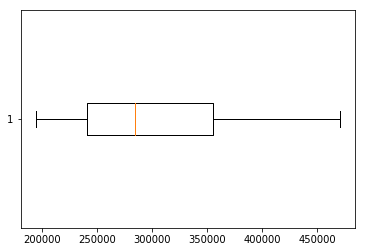

In [98]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 3, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 4

In [99]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 4, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode          City   Latitude  Longitude State  \
114               4    55359  Independence  45.002212  -93.69319    MN   

                                Metro       CountyName  SizeRank  \
114  Minneapolis-St. Paul-Bloomington  Hennepin County     10622   

     Feb-2019 Median Home Value 1st Most Common Venue 2nd Most Common Venue  \
114                      382800                  Food                  Farm   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
114           Zoo Exhibit        Farmers Market     Elementary School   

    6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
114    English Restaurant  Entertainment Service  Ethiopian Restaurant   

    9th Most Common Venue 10th Most Common Venue  
114           Event Space                Exhibit

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b343212b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b34321940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b34321160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b34321fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b34329358>],
 'means': []}

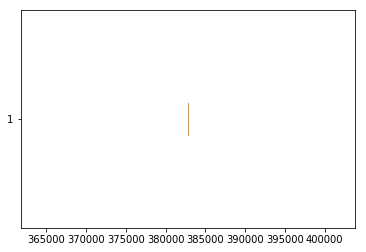

In [100]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 4, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 5

In [101]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 5, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode                   City   Latitude  Longitude  \
1                 5    55044              Lakeville  44.669564  -93.26654   
2                 5    55337             Burnsville  44.770297  -93.27302   
4                 5    55303                 Ramsey  45.247509  -93.41800   
5                 5    55113              Roseville  45.011215  -93.15536   
10                5    55125               Woodbury  44.921982  -92.94234   
13                5    55406            Minneapolis  44.938615  -93.22082   
35                5    55116             Saint Paul  44.913815  -93.17459   
36                5    55443          Brooklyn Park  45.108581  -93.33988   
38                5    55428               New Hope  45.059997  -93.37702   
42                5    55434                 Blaine  45.164248  -93.25310   
45                5    55347           Eden Prairie  44.831413  -93.46031   
52                5    55427          Golden Valley  45.006764  -93.38223   
54                5    55068              Rosemount  44.732105  -93.13437   
60                5    55025            Forest Lake  45.272117  -92.99110   
68                5    55447               Plymouth  45.003363  -93.49262   
69                5    55437            Bloomington  44.822764  -93.34422   
77                5    55441               Plymouth  45.001997  -93.42421   
89                5    55413            Minneapolis  44.997665  -93.24927   
93                5    55387                Waconia  44.849912  -93.78514   
96                5    55103             Saint Paul  44.964115  -93.12261   
97                5    55077    Inver Grove Heights  44.825391  -93.06893   
108               5    55352                 Jordan  44.657463  -93.61330   
110               5    55454            Minneapolis  44.969465  -93.24327   
113               5    55340                 Medina  45.073430  -93.56455   
117               5    55388              Watertown  44.955136  -93.84467   
133               5    55047  Marine on Saint Croix  45.195606  -92.81649   
140               5    55065               Randolph  44.534866  -93.02959   

    State                             Metro         CountyName  SizeRank  \
1      MN  Minneapolis-St. Paul-Bloomington      Dakota County       779   
2      MN  Minneapolis-St. Paul-Bloomington      Dakota County       806   
4      MN  Minneapolis-St. Paul-Bloomington       Anoka County       850   
5      MN  Minneapolis-St. Paul-Bloomington      Ramsey County       948   
10     MN  Minneapolis-St. Paul-Bloomington  Washington County      1317   
13     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      1555   
35     MN  Minneapolis-St. Paul-Bloomington      Ramsey County      3156   
36     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      3201   
38     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      3252   
42     MN  Minneapolis-St. Paul-Bloomington       Anoka County      3438   
45     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      3716   
52     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      3966   
54     MN  Minneapolis-St. Paul-Bloomington      Dakota County      4004   
60     MN  Minneapolis-St. Paul-Bloomington  Washington County      4530   
68     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      5282   
69     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      5301   
77     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      5767   
89     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      6856   
93     MN  Minneapolis-St. Paul-Bloomington      Carver County      7558   
96     MN  Minneapolis-St. Paul-Bloomington      Ramsey County      7763   
97     MN  Minneapolis-St. Paul-Bloomington      Dakota County      7772   
108    MN  Minneapolis-St. Paul-Bloomington       Scott County      9317   
110    MN  Minneapolis-St. Paul-Bloomington    Hennepin County      9503   
113    MN  Minneapolis-S

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b342fa588>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b342fac18>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b342fa438>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b343022e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b34302630>],
 'means': []}

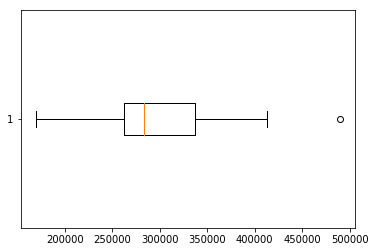

In [102]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 5, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 6

In [103]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 6, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode                   City   Latitude  Longitude  \
14                6    55379               Shakopee  44.776138  -93.52556   
22                6    55418            Minneapolis  45.019315  -93.24304   
26                6    55311            Maple Grove  45.102133  -93.48757   
30                6    55118        West Saint Paul  44.903165  -93.10026   
39                6    55128                Oakdale  44.985792  -92.96532   
40                6    55024             Farmington  44.649263  -93.15222   
47                6    55126              Shoreview  45.085643  -93.13530   
56                6    55305             Minnetonka  44.953763  -93.43346   
58                6    55014             Lino Lakes  45.153516  -93.14463   
59                6    55411            Minneapolis  44.999165  -93.29823   
71                6    55412            Minneapolis  45.027715  -93.30337   
75                6    55317             Chanhassen  44.866236  -93.54487   
81                6    55127        Vadnais Heights  45.076708  -93.08280   
82                6    55331              Shorewood  44.901368  -93.58278   
106               6    55424                  Edina  44.904414  -93.34045   
129               6    55322                Cologne  44.768762  -93.77839   
130               6    55357             Greenfield  45.088013  -93.65053   
135               6    55397  Norwood Young America  44.801162  -93.92368   

    State                             Metro         CountyName  SizeRank  \
14     MN  Minneapolis-St. Paul-Bloomington       Scott County      1596   
22     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      2457   
26     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      2716   
30     MN  Minneapolis-St. Paul-Bloomington      Dakota County      2933   
39     MN  Minneapolis-St. Paul-Bloomington  Washington County      3297   
40     MN  Minneapolis-St. Paul-Bloomington      Dakota County      3311   
47     MN  Minneapolis-St. Paul-Bloomington      Ramsey County      3811   
56     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      4205   
58     MN  Minneapolis-St. Paul-Bloomington       Anoka County      4336   
59     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      4473   
71     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      5323   
75     MN  Minneapolis-St. Paul-Bloomington      Carver County      5565   
81     MN  Minneapolis-St. Paul-Bloomington      Ramsey County      6024   
82     MN  Minneapolis-St. Paul-Bloomington    Hennepin County      6058   
106    MN  Minneapolis-St. Paul-Bloomington    Hennepin County      9102   
129    MN  Minneapolis-St. Paul-Bloomington      Carver County     13074   
130    MN  Minneapolis-St. Paul-Bloomington    Hennepin County     13312   
135    MN  Minneapolis-St. Paul-Bloomington      Carver County     13632   

     Feb-2019 Median Home Value 1st Most Common Venue  \
14                       270900                  Park   
22                       259400                  Park   
26                       368200                  Park   
30                       260900    Chinese Restaurant   
39                       252800        Sandwich Place   
40                       278900           Pizza Place   
47                       300400         Grocery Store   
56                       340200                   Gym   
58                       267900   American Restaurant   
59                       175300                  Park   
71                       171800                  Park   
75                       390800        Sandwich Place   
81                       327000        Baseball Field   
82                       562800                  Park   
106                      762500           Coffee Shop   
129                      315800                   Bar   
130                      356600           Yoga Studio   
135                      222700                  Lake   

          2n

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b342cf3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b342cfa58>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b342cf278>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b342d5128>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b342d5470>],
 'means': []}

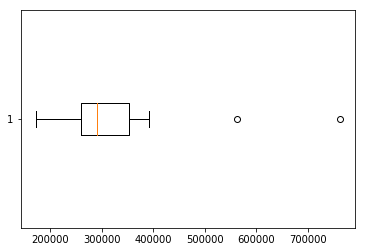

In [104]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 6, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 7

In [105]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 7, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode                 City   Latitude  Longitude State  \
65               7    55076  Inver Grove Heights  44.844833  -93.03528    MN   
74               7    55038                 Hugo  45.161267  -92.99596    MN   
90               7    55436                Edina  44.903864  -93.37056    MN   

                               Metro         CountyName  SizeRank  \
65  Minneapolis-St. Paul-Bloomington      Dakota County      4936   
74  Minneapolis-St. Paul-Bloomington  Washington County      5494   
90  Minneapolis-St. Paul-Bloomington    Hennepin County      7049   

    Feb-2019 Median Home Value 1st Most Common Venue 2nd Most Common Venue  \
65                      238200           Pizza Place                  Park   
74                      301200          Liquor Store                   ATM   
90                      486400                  Park           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
65         Grocery Store        Discount Store                   Bar   
74   American Restaurant         Grocery Store            Restaurant   
90    Salon / Barbershop                  Café    Seafood Restaurant   

   6th Most Common Venue 7th Most Common Venue       8th Most Common Venue  \
65      Asian Restaurant                 Diner                      Office   
74           Coffee Shop        Sandwich Place  Construction & Landscaping   
90         Grocery Store          Liquor Store              Shipping Store   

   9th Most Common Venue 10th Most Common Venue  
65    Salon / Barbershop         Sandwich Place  
74           Pizza Place            Fish Market  
90           Golf Course               Pharmacy

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b3421bd30>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b34224400>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b3421bbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b34224a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b34224dd8>],
 'means': []}

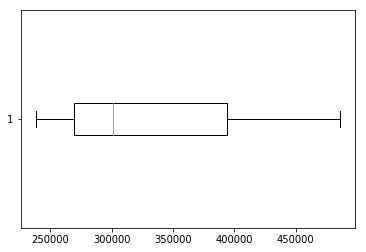

In [106]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 7, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 8

In [107]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 8, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode             City   Latitude  Longitude State  \
28                8    55343          Hopkins  44.921599 -93.408570    MN   
31                8    55422      Robbinsdale  45.014764 -93.339650    MN   
32                8    55372       Prior Lake  44.704646 -93.421390    MN   
79                8    55438      Bloomington  44.825700 -93.382120    MN   
101               8    55445    Brooklyn Park  45.112742 -93.378900    MN   
102               8    55121            Eagan  44.844965 -93.144310    MN   
119               8    55315           Carver  44.736595 -93.656190    MN   
120               8    55120  Mendota Heights  44.873398 -93.145380    MN   
138               8    55054  Elko New Market  44.571056 -93.354267    MN   

                                Metro       CountyName  SizeRank  \
28   Minneapolis-St. Paul-Bloomington  Hennepin County      2837   
31   Minneapolis-St. Paul-Bloomington  Hennepin County      3017   
32   Minneapolis-St. Paul-Bloomington     Scott County      3020   
79   Minneapolis-St. Paul-Bloomington  Hennepin County      5932   
101  Minneapolis-St. Paul-Bloomington  Hennepin County      8428   
102  Minneapolis-St. Paul-Bloomington    Dakota County      8500   
119  Minneapolis-St. Paul-Bloomington    Carver County     11406   
120  Minneapolis-St. Paul-Bloomington    Dakota County     11854   
138  Minneapolis-St. Paul-Bloomington     Scott County     14743   

     Feb-2019 Median Home Value 1st Most Common Venue 2nd Most Common Venue  \
28                       258000           Coffee Shop           Pizza Place   
31                       237700                  Park                   ATM   
32                       332800        Baseball Field  Fast Food Restaurant   
79                       314200                  Park    Chinese Restaurant   
101                      250400  Fast Food Restaurant   Arts & Crafts Store   
102                      259800        Sandwich Place   American Restaurant   
119                      341700         Auto Workshop        Scenic Lookout   
120                      379700                 Hotel   American Restaurant   
138                      314700     Convenience Store           Pizza Place   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
28      Gym / Fitness Center   Rental Car Location        Cosmetics Shop   
31            Sandwich Place       Thai Restaurant            Taco Place   
32               Pizza Place   American Restaurant     Convenience Store   
79        Mexican Restaurant     Electronics Store           Auto Garage   
101           Sandwich Place  Medical Supply Store          Liquor Store   
102              Coffee Shop                 Hotel  Fast Food Restaurant   
119               Food Court     Electronics Store     Elementary School   
120  New American Restaurant          Skating Rink          Soccer Field   
138                      Bar       Photography Lab   American Restaurant   

          6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
28           Mexican Restaurant                     Bar           Video Store   
31                  Supermarket            Liquor Store                Lounge   
32                          Bar  Thrift / Vintage Store    Chinese Restaurant   
79   Tourist Information Center                   Beach                 Trail   
101         Rental Car Location             Coffee Shop          Intersection   
102           Mobile Phone Shop             Pizza Place          Liquor Store   
119          English Restaurant   Entertainment Service  Ethiopian Restaurant   
120              Baseball Field             Golf Course          Intersection   
138        Gym / Fitness Center             Zoo Exhibit                  Farm   

      9th Most Common Venue      10th Most Common Venue  
28       Chinese Restaurant              Baseball Field  
31     Fast Food Restaurant                        Café  
32              

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b341f2198>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b341f2828>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b341f2048>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b341f2eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b341fa240>],
 'means': []}

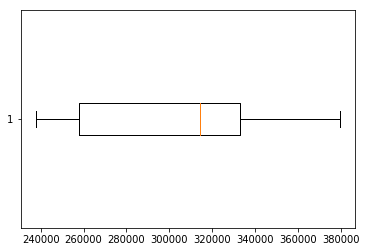

In [108]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 8, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 9

In [109]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 9, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

Cluster Labels  ZipCode              City   Latitude  Longitude State  \
3                 9    55106        Saint Paul  44.967565  -93.05001    MN   
7                 9    55112      New Brighton  45.076365  -93.19335    MN   
8                 9    55416  Saint Louis Park  44.946664  -93.34215    MN   
19                9    55407       Minneapolis  44.934915  -93.25424    MN   
33                9    55016     Cottage Grove  44.830966  -92.93739    MN   
37                9    55426  Saint Louis Park  44.952064  -93.37795    MN   
46                9    55417       Minneapolis  44.905365  -93.23662    MN   
48                9    55419       Minneapolis  44.902414  -93.29012    MN   
66                9    55345        Minnetonka  44.915413  -93.48443    MN   
73                9    55431       Bloomington  44.829564  -93.30982    MN   
80                9    55405       Minneapolis  44.971798  -93.30273    MN   
85                9    55306        Burnsville  44.732569  -93.28909    MN   
98                9    55409       Minneapolis  44.924115  -93.28362    MN   
103               9    55042         Lake Elmo  44.999023  -92.90939    MN   
107               9    56011      Belle Plaine  44.616113  -93.76906    MN   
116               9    55071   Saint Paul Park  44.835366  -92.99254    MN   
121               9    55114        Saint Paul  44.964815  -93.19581    MN   
131               9    55384       Spring Park  44.936423  -93.62868    MN   

                                Metro         CountyName  SizeRank  \
3    Minneapolis-St. Paul-Bloomington      Ramsey County       841   
7    Minneapolis-St. Paul-Bloomington      Ramsey County      1007   
8    Minneapolis-St. Paul-Bloomington    Hennepin County      1212   
19   Minneapolis-St. Paul-Bloomington    Hennepin County      1999   
33   Minneapolis-St. Paul-Bloomington  Washington County      3041   
37   Minneapolis-St. Paul-Bloomington    Hennepin County      3242   
46   Minneapolis-St. Paul-Bloomington    Hennepin County      3809   
48   Minneapolis-St. Paul-Bloomington    Hennepin County      3855   
66   Minneapolis-St. Paul-Bloomington    Hennepin County      5122   
73   Minneapolis-St. Paul-Bloomington    Hennepin County      5394   
80   Minneapolis-St. Paul-Bloomington    Hennepin County      5965   
85   Minneapolis-St. Paul-Bloomington      Dakota County      6550   
98   Minneapolis-St. Paul-Bloomington    Hennepin County      7799   
103  Minneapolis-St. Paul-Bloomington  Washington County      8877   
107  Minneapolis-St. Paul-Bloomington       Scott County      9198   
116  Minneapolis-St. Paul-Bloomington  Washington County     11002   
121  Minneapolis-St. Paul-Bloomington      Ramsey County     11929   
131  Minneapolis-St. Paul-Bloomington    Hennepin County     13377   

     Feb-2019 Median Home Value       1st Most Common Venue  \
3                        185600          Mexican Restaurant   
7                        267700                       Beach   
8                        344100                 Coffee Shop   
19                       254700               Grocery Store   
33                       259600                 Pizza Place   
37                       280300                        Park   
46                       282500          Italian Restaurant   
48                       391700          Mexican Restaurant   
66                       383200                  Hobby Shop   
73                       277500                Burger Joint   
80                       390500                 Coffee Shop   
85                       302900              Clothing Store   
98                       298800                 Coffee Shop   
103                      476300  Construction & Landscaping   
107                      236700                         Bar   
116                      221200                         Bar   
121                      251500                        Park   
131                      391600                        La

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7b341ca4a8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7b341cab38>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7b341ca358>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7b341cf208>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7b341cf550>],
 'means': []}

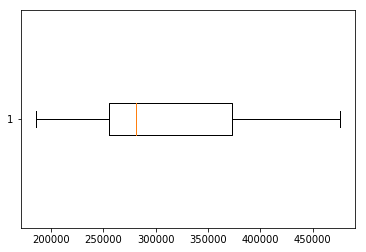

In [110]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 9, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

## Calculate 5 year CAGR and use data for choropleth map

In [111]:
zill_MSP_df.shape

(141, 70)

### geoJSON visual section

In [212]:
#zill_MSP_df.loc[0,zill_MSP_df.columns[[0] + [9]]]

# create a new dataframe as a subset of MSP_merged. Important change: Converted Zipcode from int64 to string since geoJSON has it stored as a string!
MSP_value_data = MSP_merged[['ZipCode','Feb-2019 Median Home Value']]
MSP_value_data = MSP_value_data.rename(columns={'Feb-2019 Median Home Value':'Value'})
MSP_value_data['ZipCode'] = MSP_value_data['ZipCode'].apply(str)
MSP_value_data.dtypes

ZipCode    object
Value       int64
dtype: object

import zipcode geojson data for MN from this site; use to make choropleth maps etc.; https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md

In [112]:
mn_zipcode_file = open('mn_minnesota_zip_codes_geo.json')
mn_zipcode_str = mn_zipcode_file.read()
mn_zipcode_data = json.loads(mn_zipcode_str)

Write smaller geojson for just 7 county area from full MN zipcode geojson

In [341]:
#type(mn_zipcode_data)
#for postcode in MSP_merged['ZipCode']:
#    print(postcode)

# figure out how to read element [0] into a string then dump it to a json
#MN_geoJSON_temp = mn_zipcode_data['features'][0]

#MN_geoJSON_temp = {}
#MN_geoJSON_temp.setdefault(1,mn_zipcode_data['features'][1])
#MN_geoJSON_temp[1]['properties']['ZCTA5CE10']
#del MN_geoJSON_temp


#MSP_geoJSON = {'type': 'FeatureCollection'}   # dict to store matches
#MSP_geoJSON.setdefault('features', dict())
#MSP_geoJSON

#mn_zipcode_data['features'][0]

In [113]:
#features = list(MSP_geoJSON_temp.keys())
#features = [1, 2]
#MSP_geoJSON = {'type' : 'FeatureCollection', 'features' : []}
#MSP_geoJSON = {'type' : 'FeatureCollection', 'features' : features}
count = 0
for item in mn_zipcode_data['features'][0:3]:
    for k, v in item['properties'].items():
        if k == 'ZCTA5CE10':
            print(count, ' ', v)
        count += 1
#count
#MSP_geoJSON['features'][0]['properties']
#elem

1   56469
12   55783
23   55798


In [114]:
# This block uses MSP_ZipCode_Geo

elem = 0 # use to count how many elements
# dict to store matches; Note previously had { ... 'features' : dict()} which made features keys vs items as they are now with []
MSP_geoJSON = {'type': 'FeatureCollection', 'features' : []}
MSP_geoJSON_ZipCode_List = []

# loop through all the elements in the larger JSON file (which is now stored as a python dict); there is an element for each zipcode in MN
for element in mn_zipcode_data['features']:
    # loop through each zipcode element and look for the property where the zipcode is stored
#   print(elem)
#    elem += 1
    for k, v in element['properties'].items():
        if k == 'ZCTA5CE10':
            # loop through each zipcode in MSP_merged dataset
#            for postcode in MSP_ZipCode_Geo['ZipCode']:
                # if the current value from the larger JSON file matches it a zipcode in MSP_merged add the element to MN_geoJSON dict and incr elem
                if str(v) == str(postcode):
                    MSP_geoJSON_ZipCode_List.append(v)
                    MSP_geoJSON['features'].append(mn_zipcode_data['features'][elem])
                    elem += 1    # increment the element count to keep track of how many elements

In [160]:
# This block uses MSP_merged

elem = 0 # use to count how many elements
# dict to store matches; Note previously had { ... 'features' : dict()} which made features keys vs items as they are now with []
MSP_geoJSON = {'type': 'FeatureCollection', 'features' : []}
MSP_geoJSON_ZipCode_List = []

# loop through all the elements in the larger JSON file (which is now stored as a python dict); there is an element for each zipcode in MN
for element in mn_zipcode_data['features']:
    # loop through each zipcode element and look for the property where the zipcode is stored
    for k, v in element['properties'].items():
        if k == 'ZCTA5CE10':
            # loop through each zipcode in MSP_merged dataset
            for postcode in MSP_merged['ZipCode']:
                # if the current value from the larger JSON file matches it a zipcode in MSP_merged add the element to MN_geoJSON dict and incr elem
                if str(v) == str(postcode):
                    MSP_geoJSON_ZipCode_List.append(v)
                    MSP_geoJSON['features'].append(mn_zipcode_data['features'][elem])  # flaw in logic!! [elem] should be mn_zipcode_data['features'][0 or whatever item number match found!]
            elem += 1    # increment the element count to keep track of how many elements

In [ ]:
#compare_lists(zill_MSP_df['ZipCode'], MSP_geoJSON_ZipCode_List)

In [161]:
# write MSP_geoJSON to msp_zipcode_geo.json file
#with open('msp_zipcode_geo.json', 'w') as oufile:
#    json.dump(MSP_geoJSON, oufile)

In [199]:
#MSP_geoJSON
msp_zipcode_geo = r'msp_zipcode_geo.json'
#mn_zipcode_geo = r'mn_minnesota_zip_codes_geo.json'

In [207]:
# create a map of minneapolis-st.paul metro area
msp_map = folium.Map(location=[latitude, longitude], zoom_start=9)

# this works with msp_zipcode_geo.json
folium.GeoJson(
    msp_zipcode_geo,
    name='geojson'
).add_to(msp_map)

#msp_map

In [213]:
# generate choropleth map
msp_map.choropleth(
    geo_data=msp_zipcode_geo,
    data=MSP_value_data,
    columns=['ZipCode','Value'],
    key_on='feature.properties.ZCTA5CE10',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Feb-2019 Median Home Value'
)

#folium.LayerControl().add_to(msp_map)

msp_map

In [206]:
del msp_map